In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyreadr
import numpy as np
import mplcursors

Import data

Start by running locally, we'll work our way up to reading from the internet

Overarching design for this toolbox is as follows.

First, we design a state class to house necessary information.  Now, the issue is each state has different naming conventions on how it stores its data, so we then generate a set of easy to understand names to use.  After we have the easy-to-use names, we build a map that maps the easy-to-use names to the specific term the state uses.  From there, we can now write generalizable functions in terms of the easy-to-use names, and it works for every state as long as the map is set up.

## General Terms

First, we design a universal set of names to refer to information that is needed for our analysis.  These general terms are:
1.	Year: the year the sentencing occurred.
2.	County: the county of where the sentencing occurred.
3.	District: the district the sentencing occurred.
4.	Race: the race of the individual sentenced
5.	Departure: what kind of departure, if any occurred in the sentencing.  Levels could be Above Departure (sentencing greater than guideline), Within Range,  Below Range (sentence is below the guideline), or Indeterminable.
6.	Judge: the name of the Judge that sentenced the individual
7.	Sex: the sex of the individual sentenced

The idea here is we have these general, understandable terms.  State datasets vary from state to state, so we build a map to relate the general, usable term to the specific term the state uses.  This is useful for two reasons

1.	This map makes writing functions universal because of the maps.  Since we know that we can use, for example, Year to access the year data, we can always use Year rather than have to write a new function for every state.
2.	It makes reading and writing code easy to understand.  Rather than knowing durdep means duration in the Minnesota dataset, all you have to know is the general terms and the maps do all the hard work of relating the easy term to the hard one.


# Class State
Designed to be a container to hold all the necessary information for a specific state.  This class has 3 attributes
* Name:  Stores the name of the state
* Data: stores the dataframe for that state’s data
* Paths: this is a dictionary that maps the easy to use names to the specific names the state’s dataset uses.
* Paths always has 1 of the two formats:
    1. paths\[general term\] = \[specific_state_term\]
    2. paths\[general term\] = \[specific_state_term, dictionary describing the levels of that term\]
    
State objects are the core of this toolbox.  Every function is written with a state object being passed in.  The function takes the state object, then uses the genral terms, paths, and the states data to produce the desiered output.

In [2]:
class State:
    def __init__(self, inp_name, inp_data, inp_paths):
        self.name = inp_name
        
        self.data = inp_data  # pandas dataframe object
        
        self.paths = inp_paths  # dictionary object.  
        # Always follows the format useful_id --> (name_in_data, dict(levels)).
        # Levels doesn't always exist, but is needed for variables like departure
        

This code is setting up the minnesota state

In [35]:
states = {}  # dictionary to hold all states.  maps dict['state name'] --> state object for that state
paths = {}  # temporary paths dicitonary that will be passed into the creation of minnesota state object
paths['county'] = ['countyname', None]
paths['year'] = ['sentyear', None]
paths['district'] = ['district', None]
paths['race'] = ['race', {0:'NA', 
                                 'white':'White', 
                                 'black':'Black', 
                                 'amind':'American Indian',
                                 'hispanic': 'Hispanic',
                                 'asian': 'Asian',
                                 'other': ' Other',
                                 None: 'Unknown'}]
paths['departure'] = ['durdep', {0:'Within Range', 
                                 1:'Above Departure', 
                                 2:'Below Range', 
                                 3:'Missing, Indeterminable, or Inapplicable'}]
paths['judge'] = ['judge', None]
paths['sex'] = ['sex', {1: 'male', 2: 'female'}]
paths['age'] = ['Agecat', {1: 'under 18', 2: '18-21', 3: '22-25', 4: '26-30',5: '31-40',6: '41-50',7: '51+'}]

#now that we have the information, we create the minnesota state object and add it to the states dictionary
states['minnesota'] = State('minnesota', pd.read_csv('allmnclean.csv', low_memory = False), paths)

# Plotting Functions

In [36]:
def plot_departures(departure_output, departure_porportions, subgroup, s = True):
    subgroup_str = ''
    for item in subgroup:
        subgroup_str += str(item) + ' '
    if s:  
        subgroup_str = subgroup_str[:-1]
        subgroup_str+='s'
        
    fig, ax = plt.subplots(figsize = (10,7))
    bar_colors = ['red', 'grey', 'blue', 'teal']
    
    barh = ax.barh(departure_output, departure_porportions, color=bar_colors)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Percentage')
    
    ##ax.bar_label(barh)
    ##for bars in ax.containers:
        ##ax.bar_label(barh)
    
    ttl = 'Porportional sentences for '+ subgroup_str
    ax.set_title(ttl)

In [37]:
def plot_departures_stacked(x_values_list, y_values_list, subgroup, legend, s = True):
    subgroup_str = ''
    for item in subgroup:
        subgroup_str += str(item) + ' '
    if s:  
        subgroup_str = subgroup_str[:-1]
        subgroup_str+='s'
        
    fig, ax = plt.subplots(figsize = (10,1 * len(x_values_list)))
    
    bar_colors = ['red', 'grey', 'blue', 'teal']
    
    b = np.zeros(len(x_values_list))
    for i in range(len(y_values_list)):
        ax.barh(x_values_list, y_values_list[i], left = b, color = bar_colors[i], label = legend[i])
        b += y_values_list[i]
    ax.set_xlabel('Percentage')
    ttl = 'Porportional sentences for '+ subgroup_str
    ax.set_title(ttl)
    ax.legend(bbox_to_anchor = (1.45, 0.6), loc='center right')

# Helper Functions

In [38]:
def filter_years(stateobj, years):
    '''
    Every funciton has a years to filter parameter, so we are building a function here because:
    1.  if we have to edit it, we only have to edit it here
    2.  saves us time from rewriting this a bunch
    Parameters:
    stateobj: a state object
    years: the specified years.  Either a range or none
    '''
    subset_dat = stateobj.data
    if years != None:  
        # if the user specifies a year range, filter the data for those years
        subset_dat = stateobj.data[stateobj.paths['year'] == years]
    return subset_dat

# Analysis Functions

### State aggregate

In [44]:
def state_aggregate(stateobj, years = None, stacked = False):
    subset_dat = filter_years(stateobj, years)
    
    counts = subset_dat.groupby(stateobj.paths['departure'][0]).count()
    counts = counts.rename(stateobj.paths['departure'][1])
    counts = counts.iloc[:,0]
     
    order_of_outputs = ['Above Departure', 'Within Range', 'Below Range', 'Missing, Indeterminable, or Inapplicable']
    porportions_list = []
    for item in order_of_outputs:
        porportions_list.append(round((100 * counts.at[item]  /  subset_dat.shape[0]),1))
    
    if stacked:
        arr = np.array(porportions_list)
        arr = arr.T
        plot_departures_stacked([stateobj.name], porportions_list, [stateobj.name], order_of_outputs)
    else:
        plot_departures(order_of_outputs, porportions_list, [stateobj.name], s = False)
    
    return counts

durdep
Within Range                                252971
Above Departure                               5855
Below Range                                  22208
Missing, Indeterminable, or Inapplicable     12185
Name: county, dtype: int64

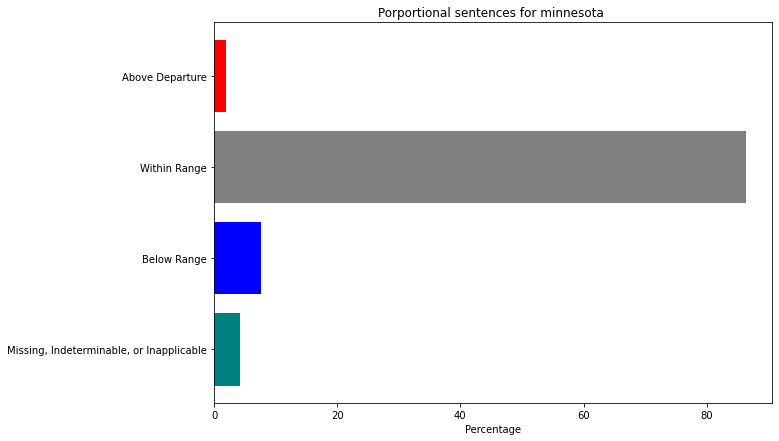

In [45]:
state_aggregate(states['minnesota'], stacked = False)

## Race profile

Grouping by race, what is the breakdown for sentencing in this state?

In [76]:
def race_profile(stateobj, years = None, stacked = True):
    # we should have a subplots vs stacked parameter here maybe?  either do lots of individual graphs or stacked
    subset_dat = filter_years(stateobj, years)
    print(type(subset_dat))
    #grouping by departure and race
    #divide by count(race) for racial percentages, to get counts, remove the denominator
    perc = round(100 * subset_dat.groupby([stateobj.paths['race'][0], stateobj.paths['departure'][0]]).count() / 
                   subset_dat.groupby([stateobj.paths['race'][0]]).count(), 1)
    counts = subset_dat.groupby([stateobj.paths['race'][0], stateobj.paths['departure'][0]]).count()
    
    # renames the values to have a description
    perc = perc.rename(stateobj.paths['race'][1], level = 0)
    perc = perc.rename(stateobj.paths['departure'][1], level = 1)
    perc = perc.iloc[:,0]  # all columns are the same, so we pull the first one
    
    counts = counts.rename(stateobj.paths['race'][1], level = 0)
    counts = counts.rename(stateobj.paths['departure'][1], level = 1)
    counts = counts.iloc[:,0]  # all columns are the same, so we pull the first one
    
    comb_df = pd.concat([counts,perc],axis=1)
    comb_df.columns = ['count', 'percent']
    
    order_of_outputs = ['Above Departure', 'Within Range', 'Below Range', 'Missing, Indeterminable, or Inapplicable']
    
    #get the order of the races four out output, may make this a function
    order_of_races = []
    for idx in perc.index:  #idx is a tuple of (race, departure_type)
        if idx[0] not in order_of_races:
            order_of_races.append(idx[0])
            
    # we want our data to be in the shape: number of levels in output (departure) x number of subgroups (race)        
    percentages = np.zeros((len(order_of_outputs), len(order_of_races)))
    for dep in range(len(order_of_outputs)):
        for race in range(len(order_of_races)):
            percentages[dep, race] = perc.loc[(order_of_races[race], order_of_outputs[dep]),]
    #warning, potential for keyerror above if sonehow we have a race that doesn't have all departure levels        
    
    if stacked:
        plot_departures_stacked(order_of_races, percentages, [stateobj.name, 'race'], order_of_outputs)
    else:
        for i in range(len(order_of_races)):
            plot_departures(order_of_outputs, percentages[:,i], [stateobj.name, order_of_races[i]])
    return comb_df

<class 'pandas.core.frame.DataFrame'>


count  percent
race            durdep                                                   
American Indian Within Range                               18509     88.8
                Above Departure                              440      2.1
                Below Range                                 1424      6.8
                Missing, Indeterminable, or Inapplicable     482      2.3
Asian           Within Range                                6049     85.5
                Above Departure                              128      1.8
                Below Range                                  501      7.1
                Missing, Indeterminable, or Inapplicable     394      5.6
Black           Within Range                               61519     79.9
                Above Departure                             2051      2.7
                Below Range                                 9576     12.4
                Missing, Indeterminable, or Inapplicable    3828      5.0
Hispanic        Within Range                               13938     86.7
                Above Departure                              297      1.8
                Below Range                                 1183      7.4
                Missing, Indeterminable, or Inapplicable     659      4.1
 Other          Within Range                                 186     84.5
                Above Departure                                5      2.3
                Below Range                                   11      5.0
                Missing, Indeterminable, or Inapplicable      18      8.2
White           Within Range                              152762     88.8
                Above Departure                             2934      1.7
                Below Range                                 9513      5.5
                Missing, Indeterminable, or Inapplicable    6804      4.0

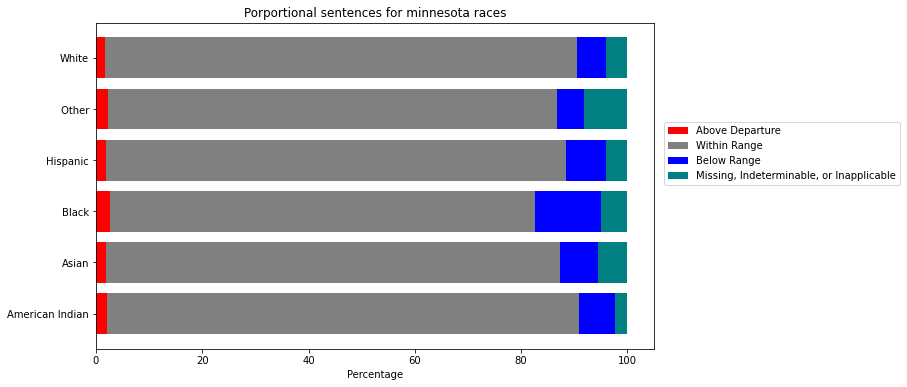

In [77]:
race_profile(states['minnesota'], stacked = True)